# 1. Simple LSTM Approach

## 1.1 Import of packages, dataset and decision point map

In [3]:
# Add FINAL/code to sys.path to import custom functions
import sys
import os
code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.insert(0, code_dir)

# ── Standard Library ─────────────────────────────────────────────
import os
import importlib
import re

# ── Data & Visualization ─────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ── Third-Party Libraries ────────────────────────────────────────
import joblib

# PM4Py (BPMN handling)
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.objects.conversion.bpmn.variants import to_petri_net

# ── Local Modules ────────────────────────────────────────────────
from preprocess import (
    extract_bpmn_decision_point_map,
)

from train import (
    train_decision_points_activities_only,
    train_model,
    build_lstm_model_activities_only,
    prepare_sequences_and_labels_activities_only
)

from evaluate import (
    compare_f1_for_trained_model,
    add_unknown_label
)

In [4]:
# Import BPMN-File
bpmn_model = bpmn_importer.apply("../resources/loan_application.bpmn")

# Convert BPMN to Petri net
net, im, fm = to_petri_net.apply(bpmn_model)

bpmn_decision_point_map = extract_bpmn_decision_point_map(bpmn_model)

In [5]:
# Path relative to current working directory
path = "../data/processed/dp_split_datasets_full_simple.joblib"

dp_split_datasets_full_simple = joblib.load(path)

print("Loaded type:", type(dp_split_datasets_full_simple))
print("Top-level keys:", list(dp_split_datasets_full_simple.keys())[:5])

Loaded type: <class 'dict'>
Top-level keys: ['DP 1', 'DP 3', 'DP 4', 'DP 5', 'DP 7']


In [6]:
SPLITS = ("train", "test", "holdout")

for dp, splits in dp_split_datasets_full_simple.items():
    for split_name in SPLITS:
        df = splits.get(split_name)
        if df is not None:
            # Keep only 'sequence' and 'label' if present
            keep_cols = [col for col in ["sequence", "label"] if col in df.columns]
            dp_split_datasets_full_simple[dp][split_name] = df[keep_cols].copy()

# Display a specific decision point's training set 
dp = "DP 48"
display(dp_split_datasets_full_simple[dp]["train"])

,sequence,label
0,"[W_Complete application, W_Complete applicatio...",O_Create Offer
1,"[A_Create Application, A_Concept, W_Complete a...",W_Complete application
2,"[W_Call after offers, W_Validate application, ...",W_Call incomplete files
3,"[W_Call after offers, W_Call after offers, W_C...",W_Call incomplete files
4,"[W_Call incomplete files, A_Incomplete, W_Call...",W_Call incomplete files
...,...,...
298597,"[A_Create Application, W_Complete application,...",O_Create Offer
298598,"[W_Validate application, W_Validate applicatio...",W_Validate application
298599,"[W_Complete application, W_Call after offers, ...",W_Validate application
298600,"[W_Call after offers, W_Call after offers, A_C...",W_Call incomplete files


## 1.2 Training for each decision point and prediction on holdout dataset

In [7]:
decision_point_models_simple, accuracy_per_class, baseline_accuracy_per_class = train_decision_points_activities_only(
    bpmn_decision_point_map=bpmn_decision_point_map,
    dp_split_datasets_simple=dp_split_datasets_full_simple
)


=== Training DP 1 ===
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6389 - loss: 0.9106 - val_accuracy: 0.6453 - val_loss: 0.8691
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6509 - loss: 0.8654 - val_accuracy: 0.6453 - val_loss: 0.8695
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 0.8691 - val_accuracy: 0.6453 - val_loss: 0.8699
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step

--- LSTM Model Results for DP 1 ---
A_Concept: Precision=0.00, Recall=0.00, F1=0.00
A_Submitted: Precision=0.65, Recall=1.00, F1=0.79
W_Complete application: Precision=0.00, Recall=0.00, F1=0.00

=== Training DP 2 ===
No split data for DP 2

=== Training DP 3 ===
Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7995 - loss: 0.4086 - val_accuracy: 0.8811 - val_loss: 0.2843
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8822 - los

In [8]:
# Convert results to DataFrames
df_accuracy = pd.DataFrame(accuracy_per_class)
df_baseline = pd.DataFrame(baseline_accuracy_per_class)

# Calculate total support per decision point (for per-DP percentage if needed)
total_support_per_dp = df_accuracy.groupby("decision_point")["support"].transform("sum")
df_accuracy["support_percentage"] = round(df_accuracy["support"] / total_support_per_dp * 100, 2)

# --- Overall Weighted Metrics ---
weighted_precision_lstm = (df_accuracy["precision"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_recall_lstm = (df_accuracy["recall"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()
weighted_f1_lstm = (df_accuracy["f1_score"] * df_accuracy["support"]).sum() / df_accuracy["support"].sum()

weighted_precision_majority = (df_baseline["precision"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_recall_majority = (df_baseline["recall"] * df_baseline["support"]).sum() / df_baseline["support"].sum()
weighted_f1_majority = (df_baseline["f1_score"] * df_baseline["support"]).sum() / df_baseline["support"].sum()

# Relative improvements
relative_improvement_f1 = (weighted_f1_lstm - weighted_f1_majority) / weighted_f1_majority * 100
relative_improvement_precision = (weighted_precision_lstm - weighted_precision_majority) / weighted_precision_majority * 100
relative_improvement_recall = (weighted_recall_lstm - weighted_recall_majority) / weighted_recall_majority * 100

# --- Print Global Comparison ---
print("\n=== Global Comparison Across All Decision Points ===")
print(f"Weighted Precision (LSTM):     {weighted_precision_lstm:.3f}")
print(f"Weighted Precision (Majority): {weighted_precision_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_precision:.2f}%\n")

print(f"Weighted Recall (LSTM):        {weighted_recall_lstm:.3f}")
print(f"Weighted Recall (Majority):    {weighted_recall_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_recall:.2f}%\n")

print(f"Weighted F1 (LSTM):            {weighted_f1_lstm:.3f}")
print(f"Weighted F1 (Majority):        {weighted_f1_majority:.3f}")
print(f"Relative Improvement:          {relative_improvement_f1:.2f}%")


=== Global Comparison Across All Decision Points ===
Weighted Precision (LSTM):     83.720
Weighted Precision (Majority): 40.690
Relative Improvement:          105.75%

Weighted Recall (LSTM):        86.710
Weighted Recall (Majority):    40.639
Relative Improvement:          113.37%

Weighted F1 (LSTM):            84.017
Weighted F1 (Majority):        40.665
Relative Improvement:          106.61%


## 1.3 Comparison of Majority Predictor & LSTM per Decision Point on Holdout-Dataset

In [9]:
# Step: Build holdout data dict from dp_split_datasets
test_data_per_dp = {
    dp_name: splits["holdout"]
    for dp_name, splits in dp_split_datasets_full_simple.items()
    if "holdout" in splits and not splits["holdout"].empty
}

# Step: Run evaluation using your existing function
for dp in test_data_per_dp.keys():
    compare_f1_for_trained_model(dp, test_data_per_dp, decision_point_models_simple)

AttributeError: 'NoneType' object has no attribute 'classes_'

## 1.4 Evaluation Plots and Metrics

In [10]:
# --- Per-Decision Point Aggregates ---
dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)

dp_metrics_baseline = df_baseline.groupby("decision_point").apply(
    lambda g: pd.Series({
        "precision": (g["precision"] * g["support"]).sum() / g["support"].sum(),
        "recall": (g["recall"] * g["support"]).sum() / g["support"].sum(),
        "f1_score": (g["f1_score"] * g["support"]).sum() / g["support"].sum()
    })
)

# --- Mean and Std per model ---
mean_precision_lstm = dp_metrics_lstm["precision"].mean()
std_precision_lstm = dp_metrics_lstm["precision"].std()

mean_recall_lstm = dp_metrics_lstm["recall"].mean()
std_recall_lstm = dp_metrics_lstm["recall"].std()

mean_f1_lstm = dp_metrics_lstm["f1_score"].mean()
std_f1_lstm = dp_metrics_lstm["f1_score"].std()

mean_precision_baseline = dp_metrics_baseline["precision"].mean()
std_precision_baseline = dp_metrics_baseline["precision"].std()

mean_recall_baseline = dp_metrics_baseline["recall"].mean()
std_recall_baseline = dp_metrics_baseline["recall"].std()

mean_f1_baseline = dp_metrics_baseline["f1_score"].mean()
std_f1_baseline = dp_metrics_baseline["f1_score"].std()

# --- Print Global + Std ---
print("\n=== Aggregated Across Decision Points ===")
print(f"Precision (LSTM):     {mean_precision_lstm:.3f} ± {std_precision_lstm:.3f}")
print(f"Precision (Baseline): {mean_precision_baseline:.3f} ± {std_precision_baseline:.3f}\n")

print(f"Recall (LSTM):        {mean_recall_lstm:.3f} ± {std_recall_lstm:.3f}")
print(f"Recall (Baseline):    {mean_recall_baseline:.3f} ± {std_recall_baseline:.3f}\n")

print(f"F1-score (LSTM):      {mean_f1_lstm:.3f} ± {std_f1_lstm:.3f}")
print(f"F1-score (Baseline):  {mean_f1_baseline:.3f} ± {std_f1_baseline:.3f}")


=== Aggregated Across Decision Points ===
Precision (LSTM):     84.505 ± 9.908
Precision (Baseline): 49.678 ± 18.679

Recall (LSTM):        87.902 ± 6.287
Recall (Baseline):    49.533 ± 18.577

F1-score (LSTM):      85.018 ± 8.586
F1-score (Baseline):  49.603 ± 18.628


/var/folders/k2/hzfndw3122558nl50cv1qnrh0000gp/T/ipykernel_41568/1819151002.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_lstm = df_accuracy.groupby("decision_point").apply(
/var/folders/k2/hzfndw3122558nl50cv1qnrh0000gp/T/ipykernel_41568/1819151002.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dp_metrics_baseline = df_baseline.groupby("decision_point").apply(


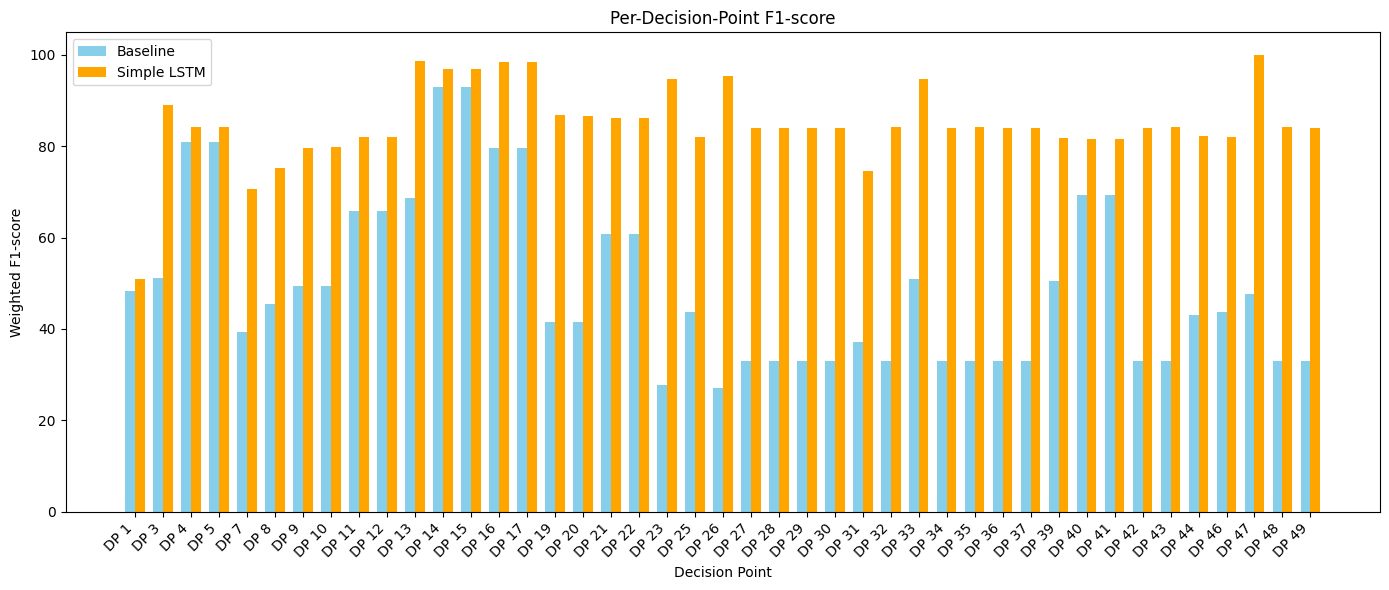

In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Combine metrics
dp_metrics = pd.DataFrame({
    "baseline_f1": dp_metrics_baseline["f1_score"],
    "lstm_f1": dp_metrics_lstm["f1_score"]
})

# Extract numeric part for sorting
def extract_dp_number(dp_name):
    match = re.search(r'\d+', dp_name)
    return int(match.group()) if match else float('inf')

dp_metrics["dp_number"] = dp_metrics.index.map(extract_dp_number)
dp_metrics = dp_metrics.sort_values("dp_number")

# Plot
x = np.arange(len(dp_metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width/2, dp_metrics["baseline_f1"], width, label="Baseline", color="skyblue")
bars2 = ax.bar(x + width/2, dp_metrics["lstm_f1"], width, label="Simple LSTM", color="orange")

ax.set_xlabel("Decision Point")
ax.set_ylabel("Weighted F1-score")
ax.set_title("Per-Decision-Point F1-score")
ax.set_xticks(x)
ax.set_xticklabels(dp_metrics.index, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

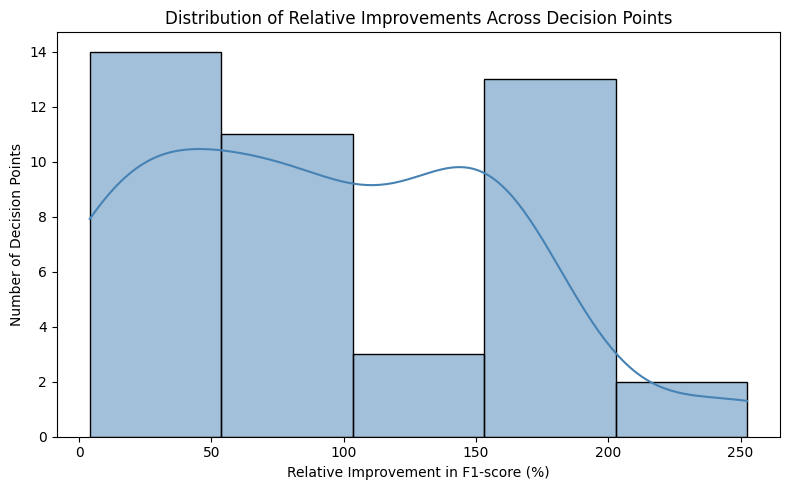

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate %ΔF1 for each decision point
relative_improvement_f1_dp = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"])
    / dp_metrics_baseline["f1_score"] * 100
)

# Plot histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(relative_improvement_f1_dp, bins=5, kde=True, color="steelblue", edgecolor="black")

# Labels and title
plt.xlabel("Relative Improvement in F1-score (%)")
plt.ylabel("Number of Decision Points")
plt.title("Distribution of Relative Improvements Across Decision Points")

plt.tight_layout()
plt.show()


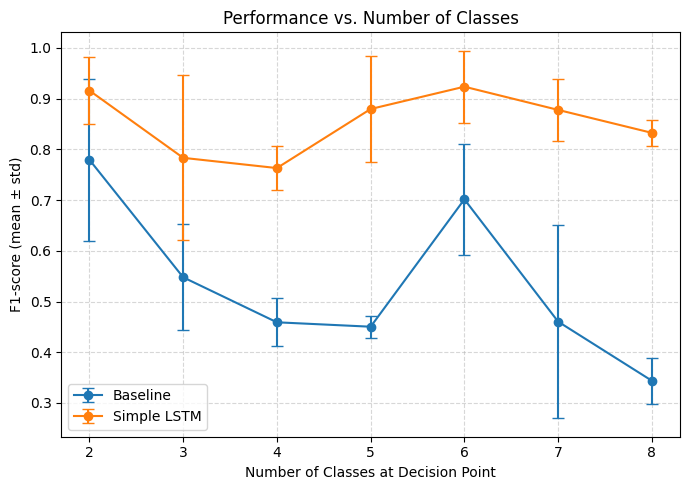

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Get number of classes per decision point ---
num_classes_per_dp = (
    df_accuracy.groupby("decision_point")["label"]
    .nunique()
    .reset_index()
    .rename(columns={"label": "num_classes"})
)

# --- 2. Merge per-DP metrics with number of classes ---
dp_perf = pd.merge(
    dp_metrics_lstm.reset_index(),
    dp_metrics_baseline.reset_index(),
    on="decision_point",
    suffixes=("_lstm", "_baseline")
)
dp_perf = pd.merge(dp_perf, num_classes_per_dp, on="decision_point")

# --- 3. Convert percentage values to fraction scale ---
metric_cols = ["precision_lstm", "recall_lstm", "f1_score_lstm",
               "precision_baseline", "recall_baseline", "f1_score_baseline"]

for col in metric_cols:
    if dp_perf[col].max() > 1:  # Means it's in percentage
        dp_perf[col] = dp_perf[col] / 100.0

# --- 4. Group by num_classes and calculate mean & std (numeric only) ---
grouped = dp_perf.groupby("num_classes")[metric_cols].agg(["mean", "std"])

# --- 5. Plot Baseline vs LSTM F1-score with error bars ---
plt.figure(figsize=(7, 5))
plt.errorbar(
    grouped.index, grouped["f1_score_baseline"]["mean"],
    yerr=grouped["f1_score_baseline"]["std"],
    fmt='o-', capsize=4, label="Baseline"
)
plt.errorbar(
    grouped.index, grouped["f1_score_lstm"]["mean"],
    yerr=grouped["f1_score_lstm"]["std"],
    fmt='o-', capsize=4, label="Simple LSTM"
)

plt.xlabel("Number of Classes at Decision Point")
plt.ylabel("F1-score (mean ± std)")
plt.title("Performance vs. Number of Classes")
plt.xticks(grouped.index)  # Show exact class counts on x-axis
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

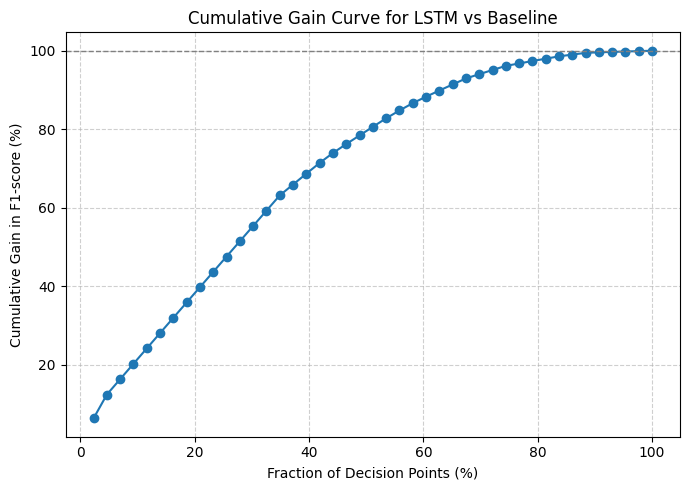

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
).sort_values(ascending=False)

# --- 2. Compute cumulative sum (normalized to 100%) ---
cumulative_gain = dp_improvement.cumsum()
cumulative_gain_normalized = cumulative_gain / cumulative_gain.iloc[-1] * 100

# --- 3. X-axis: fraction of decision points ---
dp_fraction = np.arange(1, len(dp_improvement) + 1) / len(dp_improvement) * 100

# --- 4. Plot ---
plt.figure(figsize=(7, 5))
plt.plot(dp_fraction, cumulative_gain_normalized, marker="o")
plt.axhline(100, color="gray", linestyle="--", linewidth=1)

plt.xlabel("Fraction of Decision Points (%)")
plt.ylabel("Cumulative Gain in F1-score (%)")
plt.title("Cumulative Gain Curve for LSTM vs Baseline")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


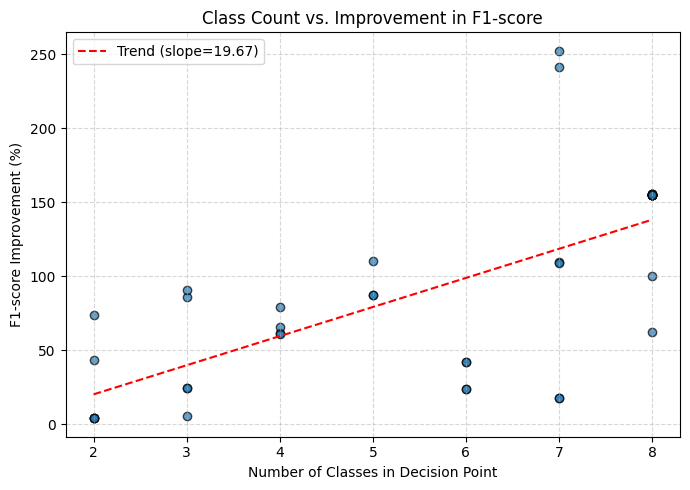

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Calculate %ΔF1 per DP ---
dp_improvement = (
    (dp_metrics_lstm["f1_score"] - dp_metrics_baseline["f1_score"]) /
    dp_metrics_baseline["f1_score"] * 100
)

# --- 2. Get number of classes per DP ---
num_classes_per_dp = df_accuracy.groupby("decision_point")["label"].nunique()

# Align with dp_improvement index
num_classes_per_dp = num_classes_per_dp.loc[dp_improvement.index]

# --- 3. Scatter plot ---
plt.figure(figsize=(7, 5))
plt.scatter(num_classes_per_dp, dp_improvement, alpha=0.7, edgecolor="black")

# --- 4. Fit regression line ---
coef = np.polyfit(num_classes_per_dp, dp_improvement, 1)
poly1d_fn = np.poly1d(coef)
x_vals = np.linspace(num_classes_per_dp.min(), num_classes_per_dp.max(), 100)
plt.plot(x_vals, poly1d_fn(x_vals), color="red", linestyle="--", label=f"Trend (slope={coef[0]:.2f})")

# --- 5. Labels & formatting ---
plt.xlabel("Number of Classes in Decision Point")
plt.ylabel("F1-score Improvement (%)")
plt.title("Class Count vs. Improvement in F1-score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 1.5  Full Training and Storage

In [ ]:
final_models_simple = {}

for decision_point, splits in dp_split_datasets_full_simple.items():
    print(f"\n--- Training FINAL (activities-only) model for {decision_point} ---")

    try:
        # ── Merge all splits ───────────────────────────────────────
        df_train = splits.get("train")
        df_test  = splits.get("test")
        df_hold  = splits.get("holdout")

        if any(x is None for x in (df_train, df_test, df_hold)):
            print(f"Skipping {decision_point} (missing split).")
            continue

        df_full = pd.concat([df_train, df_test, df_hold], ignore_index=True)
        if df_full.empty:
            print(f"Skipping {decision_point} (no data).")
            continue

        # ── Encode activities & labels (activities-only) ───────────
        X_acts, act_enc, lbl_enc, y, max_len = prepare_sequences_and_labels_activities_only(df_full)

        # ── Guarantee UNKNOWN in encoders (for robustness at inference) ──
        # Note: We mirror your previous logic and also add UNKNOWN to lbl_enc.
        # This adds an extra class with no training samples, which is acceptable for robustness.
        add_unknown_label(act_enc, "UNKNOWN")
        add_unknown_label(lbl_enc, "UNKNOWN")

        # ── Build & train LSTM (activities-only) ───────────────────
        model = build_lstm_model_activities_only(
            num_activities=len(act_enc.classes_),
            max_seq_len=max_len,
            num_classes=len(lbl_enc.classes_)
        )

        # Uses your existing train_model utility (expects a list of inputs)
        train_model(model, [X_acts], y)

        # ── Persist everything ─────────────────────────────────────
        final_models_simple[decision_point] = {
            "model":            model,
            "activity_encoder": act_enc,
            "resource_encoder": None,      # not used in activities-only
            "label_encoder":    lbl_enc,
            "context_keys":     [],        # not used
            "context_encoders": {},        # not used
            "max_seq_len":      max_len,
        }
        print(f"{decision_point}: trained & stored (activities-only).")

    except Exception as e:
        print(f"{decision_point}: error during training → {e}")


=== Training DP 1 ===
Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7640 - loss: 0.5125 - val_accuracy: 0.9771 - val_loss: 0.0987
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0700 - val_accuracy: 1.0000 - val_loss: 0.0193
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 0.0054
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- LSTM Model Results for DP 1 ---
A_Concept: Precision=1.00, Recall=1.00, F1=1.00
A_Submitted: Precision=1.00, Recall=1.00, F1=1.00
W_Complete application: Precision=1.00, Recall=1.00, F1=1.00

=== Training DP 2 

In [ ]:
save_dir = os.path.join("..", "models", "models_simple_final_full_activities_only")
os.makedirs(save_dir, exist_ok=True)

for dp_name, data in decision_point_models_simple.items():
    dp_path = os.path.join(save_dir, dp_name)
    os.makedirs(dp_path, exist_ok=True)

    # Save Keras model
    model_path = os.path.join(dp_path, "model.keras")
    data["model"].save(model_path)

    # Save encoders (only activity & label encoder are real here)
    joblib.dump(data["activity_encoder"], os.path.join(dp_path, "activity_encoder.pkl"))
    joblib.dump(data["label_encoder"], os.path.join(dp_path, "label_encoder.pkl"))

    # Save metadata
    metadata = {
        "max_seq_len": data["max_seq_len"]
    }
    joblib.dump(metadata, os.path.join(dp_path, "metadata.pkl"))

print(f"Saved models to {os.path.abspath(save_dir)}")